# Data Cleaning and Preparation with Pandas
## Data-oriented programming paradigms 2021W
---
<img src="http://ifs.tuwien.ac.at/~piroi/logos/logo-tuwien-informatics.png" width="300">

In [1]:
import pandas as pd
import numpy as np
import sys as sys
import scipy
import seaborn
from pympler import asizeof
from sklearn import preprocessing

# Coding

### Ordinal data: Categorical

In [2]:
# Note: CategoricalDtype was introduced in Pandas v 0.21.0 (released Oct 27, 2017)
from pandas.api.types import CategoricalDtype

colors_raw = pd.Series(['green','blue','brown','grey'])
colors_cat = CategoricalDtype(
    categories=colors_raw, 
    ordered=False)

eyes_data = pd.Series(['brown','blue','green','grey','brown','green','blue'])
eyes_cat = eyes_data.astype(colors_cat)

In [3]:
eyes_data

0    brown
1     blue
2    green
3     grey
4    brown
5    green
6     blue
dtype: object

In [4]:
eyes_cat

0    brown
1     blue
2    green
3     grey
4    brown
5    green
6     blue
dtype: category
Categories (4, object): [green, blue, brown, grey]

Quick memory footprint comparison...

In [5]:
print('n=7')
print('As string:      ' + str(asizeof.asizeof(eyes_data)) + ' bytes')
print('As categorical: ' + str(asizeof.asizeof(eyes_cat)) + ' bytes')

print('\nn=7000')
eyes_data_big = eyes_data
eyes_cat_big = eyes_cat
for i in range(999):
    eyes_data_big = eyes_data_big.append(eyes_data)
    eyes_cat_big = eyes_cat_big.append(eyes_cat)

print('As string:      ' + str(asizeof.asizeof(eyes_data_big)) + ' bytes')
print('As categorical: ' + str(asizeof.asizeof(eyes_cat_big)) + ' bytes')

n=7
As string:      3352 bytes
As categorical: 6560 bytes

n=7000
As string:      658376 bytes
As categorical: 195768 bytes


#### One-hot coding (dummy variables)

In [7]:
dummyCoded = pd.get_dummies(eyes_cat)

In [8]:
dummyCoded

,green,blue,brown,grey
0,0,0,1,0
1,0,1,0,0
2,1,0,0,0
3,0,0,0,1
4,0,0,1,0
5,1,0,0,0
6,0,1,0,0


### Nominal data

- Use *Categorical* and set *ordered=True*
- Useful for sorting
- Comparison operators based on category orders do not work (yet)

In [9]:
telescopeSizes = CategoricalDtype(ordered = True,
                                  categories = ['very large', 
                                              'extremely large', 
                                              'overwhelmingly large'])

telescopeData = pd.Series(
    ['very large', 'extremely large', 'overwhelmingly large'], 
    index=['VLT', 'ELT', 'OLT'], name="size")

telescopesCat = telescopeData.astype(telescopeSizes)

In [10]:
telescopesCat

VLT              very large
ELT         extremely large
OLT    overwhelmingly large
Name: size, dtype: category
Categories (3, object): [very large < extremely large < overwhelmingly large]

#### One-hot Coding

In [11]:
pd.get_dummies(telescopesCat)

,very large,extremely large,overwhelmingly large
VLT,1,0,0
ELT,0,1,0
OLT,0,0,1


#### Convert ordinal/nominal to interval/ratio

In [12]:
def size_to_numeric(x):
    if x == 'very large':
        return 8.2
    if x == 'extremely large':
        return 39
    if x == 'overwhelmingly large':
        return 100


telescopes_num = telescopesCat.apply(size_to_numeric)

In [13]:
telescopes_num.astype('float')

VLT      8.2
ELT     39.0
OLT    100.0
Name: size, dtype: float64

# Binning

### Specific boundaries

In [14]:
ages = [20, 22, 25, 27, 21, 23, 37, 31, 61, 45, 41, 32]

In [15]:
bins = [18, 25, 35, 60, 100]
ageBrackets = pd.cut(ages, bins)

In [16]:
ageBrackets

[(18, 25], (18, 25], (18, 25], (25, 35], (18, 25], ..., (25, 35], (60, 100], (35, 60], (35, 60], (25, 35]]
Length: 12
Categories (4, interval[int64]): [(18, 25] < (25, 35] < (35, 60] < (60, 100]]

The object pandas returns is a special Categorical object. The output you see describes the bins computed by pandas.cut. You can treat it like an array of strings indicating the bin name; internally it contains a categories array specifying the distinct category names along with a labeling for the ages data in the codes attribute:

In [17]:
ageBrackets.codes

array([0, 0, 0, 1, 0, 0, 2, 1, 3, 2, 2, 1], dtype=int8)

In [18]:
ageBrackets.categories

IntervalIndex([(18, 25], (25, 35], (35, 60], (60, 100]],
              closed='right',
              dtype='interval[int64]')

In [19]:
pd.value_counts(ageBrackets)

(18, 25]     5
(35, 60]     3
(25, 35]     3
(60, 100]    1
dtype: int64

### Evenly spaced

If we pass the number of bins we want, Pandas will compute equal-length bins based on min and max values in the data:

In [20]:
cats = pd.cut(ages, 4, precision=2)

In [21]:
pd.value_counts(cats)

(19.96, 30.25]    6
(30.25, 40.5]     3
(40.5, 50.75]     2
(50.75, 61.0]     1
dtype: int64

### Density-based (qcat)

In [22]:
#data = np.random.randn(1000)  # Normally distributed

cats = pd.qcut(ages, 4)  # Cut into quartiles

In [23]:
pd.value_counts(cats)

(38.0, 61.0]       3
(29.0, 38.0]       3
(22.75, 29.0]      3
(19.999, 22.75]    3
dtype: int64

# Handling missing data

Let's create some missing values...

In [24]:
df = pd.DataFrame(np.random.randn(3, 3), index=['a', 'c', 'e'], columns=['one', 'two', 'three'])
df = df.round(2)
df

,one,two,three
a,-0.68,-0.62,0.01
c,0.71,0.21,-0.91
e,0.80,-0.63,0.87


In [25]:
df = df.reindex(['a', 'b', 'c', 'd', 'e'])
df

,one,two,three
a,-0.68,-0.62,0.01
b,NaN,NaN,NaN
c,0.71,0.21,-0.91
d,NaN,NaN,NaN
e,0.80,-0.63,0.87


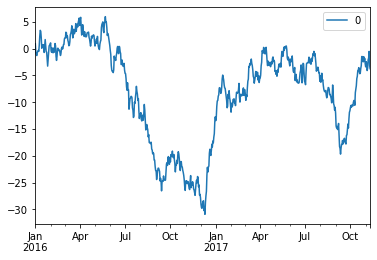

In [26]:
%matplotlib inline  
timeSeries = pd.Series(np.random.randn(680),
             index=pd.date_range('2016-01-01',
                                  '2017-11-10'))
walk_ts = pd.DataFrame(timeSeries.cumsum())
walk_ts.plot()

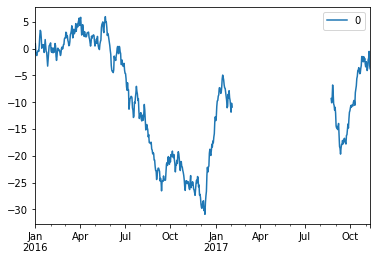

In [27]:
walk_ts.iloc[400:600] = None
walk_ts.plot()

### Filter

In [28]:
dropped = df.dropna()

In [29]:
display(df, df.dropna())

,one,two,three
a,-0.68,-0.62,0.01
b,NaN,NaN,NaN
c,0.71,0.21,-0.91
d,NaN,NaN,NaN
e,0.80,-0.63,0.87


,one,two,three
a,-0.68,-0.62,0.01
c,0.71,0.21,-0.91
e,0.80,-0.63,0.87


In [30]:
walk2 = walk_ts.dropna()

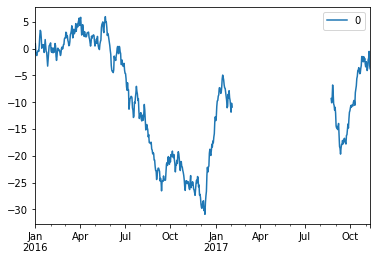

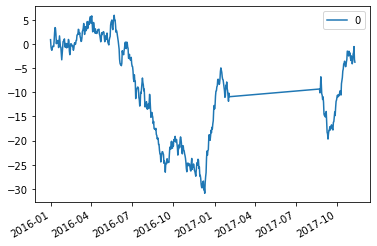

In [31]:
walk_ts.plot()
walk2.plot()

In [32]:
display('Before: ' + str(walk_ts.size) + ' values ', 'After: ' + str(walk2.size) + ' values')

'Before: 680 values '

'After: 480 values'

### Fill forward/backward

In [33]:
filled = df.fillna(method='pad') # forward fill
# filled = df.fillna(method='bfill') # back fill

In [34]:
display(df, filled)

,one,two,three
a,-0.68,-0.62,0.01
b,NaN,NaN,NaN
c,0.71,0.21,-0.91
d,NaN,NaN,NaN
e,0.80,-0.63,0.87


,one,two,three
a,-0.68,-0.62,0.01
b,-0.68,-0.62,0.01
c,0.71,0.21,-0.91
d,0.71,0.21,-0.91
e,0.80,-0.63,0.87


In [35]:
walk2 = walk_ts.fillna(method='pad')

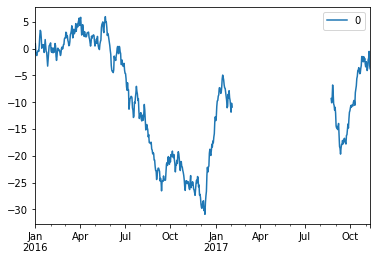

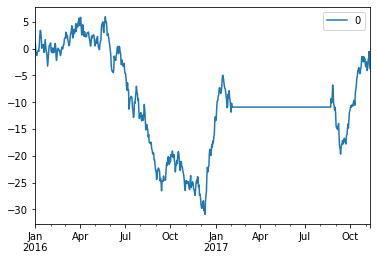

In [36]:
walk_ts.plot()
walk2.plot()

In [37]:
display('Before: ' + str(walk_ts.size) + ' values ', 'After: ' + str(walk2.size) + ' values')

'Before: 680 values '

'After: 680 values'

### Fill with the mean or value

In [38]:
meanFill = df.fillna(df.mean())

In [39]:
display(df, meanFill)

,one,two,three
a,-0.68,-0.62,0.01
b,NaN,NaN,NaN
c,0.71,0.21,-0.91
d,NaN,NaN,NaN
e,0.80,-0.63,0.87


,one,two,three
a,-0.680000,-0.620000,0.01
b,0.276667,-0.346667,-0.01
c,0.710000,0.210000,-0.91
d,0.276667,-0.346667,-0.01
e,0.800000,-0.630000,0.87


In [40]:
medianFill = df.fillna(df.median())

In [41]:
display(df, medianFill)

,one,two,three
a,-0.68,-0.62,0.01
b,NaN,NaN,NaN
c,0.71,0.21,-0.91
d,NaN,NaN,NaN
e,0.80,-0.63,0.87


,one,two,three
a,-0.68,-0.62,0.01
b,0.71,-0.62,0.01
c,0.71,0.21,-0.91
d,0.71,-0.62,0.01
e,0.80,-0.63,0.87


In [42]:
walk2 = walk_ts.fillna(walk2.mean())

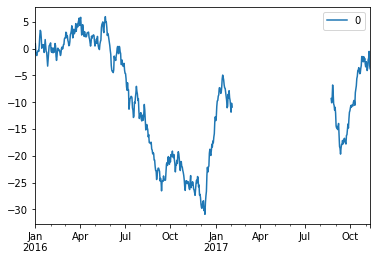

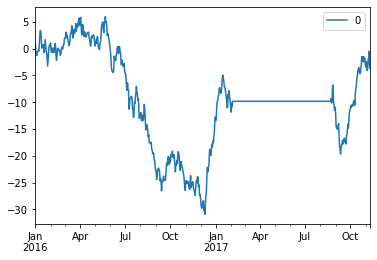

In [43]:
walk_ts.plot()
walk2.plot()

### Interpolate

In [44]:
interpolated = df.interpolate(method='linear') # linear by default,but many scipy interpolations methods available (spline, polynomial, akima,..)

In [45]:
interpolated

,one,two,three
a,-0.680,-0.620,0.01
b,0.015,-0.205,-0.45
c,0.710,0.210,-0.91
d,0.755,-0.210,-0.02
e,0.800,-0.630,0.87


#### Index-aware interpolation

In [46]:
walk2 = walk_ts.interpolate(method='time')

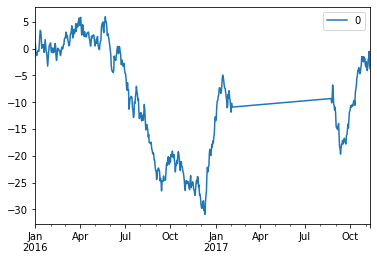

In [47]:
walk2.plot()

In [48]:
ser = pd.Series({0: 0.0, 1:2, 6:8, 10:10})
ser

0      0.0
1      2.0
6      8.0
10    10.0
dtype: float64

In [49]:
ser = ser.reindex(range(10))
ser

0    0.0
1    2.0
2    NaN
3    NaN
4    NaN
5    NaN
6    8.0
7    NaN
8    NaN
9    NaN
dtype: float64

In [50]:
ser.interpolate(method='values')

0    0.0
1    2.0
2    3.2
3    4.4
4    5.6
5    6.8
6    8.0
7    8.0
8    8.0
9    8.0
dtype: float64

(btw: these interpolation methods can also be used for reinexing)

# Detecting and Filtering Outliers

Let's create some normally distributed data..

In [51]:
data = pd.DataFrame(np.random.randn(1000, 4))

In [52]:
display(data.head(), data.describe())

,0,1,2,3
0,-0.693682,0.699080,0.978211,-1.153020
1,-0.860939,-0.113965,0.942943,-0.408016
2,-0.490050,-1.591565,-0.499445,-0.732027
3,-0.269926,-0.790933,0.995971,-1.448728
4,0.081530,1.598995,-0.722713,0.141088


,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.019452,0.000006,0.003362,-0.003107
std,1.012243,1.002512,1.028177,0.994693
min,-3.261118,-3.493444,-2.967625,-3.051584
25%,-0.688858,-0.657164,-0.709262,-0.623199
50%,-0.024500,-0.049845,-0.016810,0.038792
75%,0.684936,0.676116,0.694575,0.618331
max,2.937347,3.524565,3.420137,3.307506


Select all rows having a value exceeding 3 or –3:

In [53]:
data[(np.abs(data) > 3).any(1)]

,0,1,2,3
84,0.452254,-3.493444,-1.299319,0.191314
108,-1.664038,0.271931,1.820831,-3.051584
115,-3.261118,-0.402958,0.797439,-2.748280
129,-3.181827,0.076727,1.180922,0.821861
151,-3.105936,-0.260439,1.219654,0.108077
226,1.092729,3.129595,-0.891837,-0.103786
428,-0.325400,3.524565,0.968213,-1.334014
495,2.261114,-3.039812,-0.518218,-1.076661
509,0.240666,-1.190283,3.420137,-1.284355
540,-0.605523,-3.202686,-2.123386,1.172146


We can then, e.g., cap the values outside the interval -3 to 3:

In [54]:
data[np.abs(data) > 3] = np.sign(data) * 3
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.018647,-0.000118,0.002780,-0.003313
std,1.009796,0.997409,1.026385,0.993408
min,-3.000000,-3.000000,-2.967625,-3.000000
25%,-0.688858,-0.657164,-0.709262,-0.623199
50%,-0.024500,-0.049845,-0.016810,0.038792
75%,0.684936,0.676116,0.694575,0.618331
max,2.937347,3.000000,3.000000,3.000000


## Scaling data

In [55]:
df = pd.DataFrame({'A':[14.00,90.20,90.95,96.27,91.21],
                   'B':[103.02,107.26,110.35,114.23,114.68], 
                   'C':[1.0,2.0,3.0,4.0,5.0]})
df

,A,B,C
0,14.00,103.02,1.0
1,90.20,107.26,2.0
2,90.95,110.35,3.0
3,96.27,114.23,4.0
4,91.21,114.68,5.0


#### Rescale to [0,1] (min-max scaling)

![minMaxForumla](imgs/minMaxFormula.svg)

In [56]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()

df_rescaled = scaler.fit_transform(df)
df_rescaled

array([[0.        , 0.        , 0.        ],
       [0.92621855, 0.36363636, 0.25      ],
       [0.93533487, 0.62864494, 0.5       ],
       [1.        , 0.96140652, 0.75      ],
       [0.9384952 , 1.        , 1.        ]])

#### Normalize (mean)
![Normualize Formula](imgs/meanFormula.svg)

In [57]:
df_norm = preprocessing.StandardScaler().fit_transform(df)
df_norm

array([[-1.99528969, -1.5711172 , -1.41421356],
       [ 0.43635594, -0.60399511, -0.70710678],
       [ 0.46028946,  0.10081792,  0.        ],
       [ 0.63005789,  0.98582586,  0.70710678],
       [ 0.46858641,  1.08846854,  1.41421356]])

#### Standardize (z-score)
![Standardize Formula](imgs/standardizeFormula.svg)

In [58]:
df_stand = (df - df.mean()) / df.std()
df_stand

,A,B,C
0,-1.784641,-1.405250,-1.264911
1,0.390289,-0.540230,-0.632456
2,0.411695,0.090174,0.000000
3,0.563541,0.881749,0.632456
4,0.419116,0.973556,1.264911


In [59]:
df_stand.describe()

,A,B,C
count,5.000000e+00,5.000000e+00,5.000000e+00
mean,1.221245e-16,2.886580e-15,4.440892e-17
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.784641e+00,-1.405250e+00,-1.264911e+00
25%,3.902886e-01,-5.402297e-01,-6.324555e-01
50%,4.116954e-01,9.017429e-02,0.000000e+00
75%,4.191164e-01,8.817495e-01,6.324555e-01
max,5.635409e-01,9.735559e-01,1.264911e+00
